In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
from scipy.optimize import minimize

In [2]:
#Activator system
def CLE(beta2, k2, n2, alpha, dt):
    x = [x0]
    for i in range(len(t) - 1):
        dxi = np.random.normal(0, 1, 3) 
        x_curr = x[-1]
        
        

        F = (
            
            beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2))) -
            alpha * x_curr)
        
        G = (
            
            np.sqrt(beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2)))) * dxi[1] +
            np.sqrt(alpha * x_curr) * dxi[2])
        
        x_next = x_curr + dt * F + np.sqrt(dt) * G

        x = np.hstack([x, x_next])
    return x


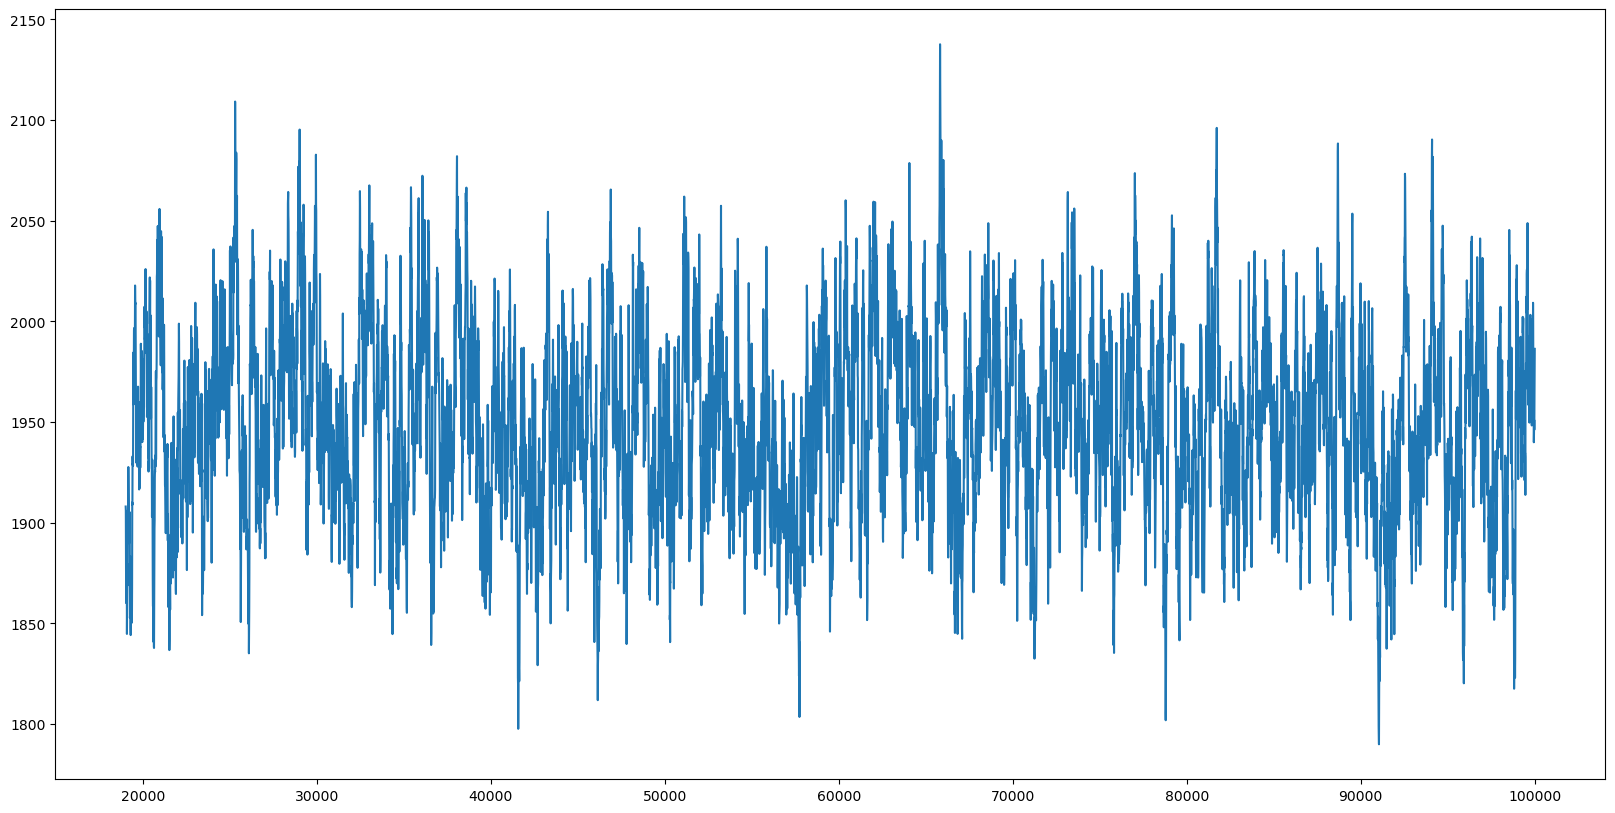

In [4]:
beta2=20
k2=50
n2=1
alpha=0.01
t = np.linspace(10000,100000,10000)
dt = t[1] - t[0]
x0=200
x_cle = CLE( beta2,k2, n2, alpha, dt)
x_cle_trimmed = x_cle[1000:]
t_trimmed = t[1000:]
plt.figure(figsize=(20, 10))
plt.plot(t_trimmed, x_cle_trimmed, label='cle')

In [6]:
def f_rep(x_cle_trimmed, k1, n1, beta1):
    return beta1 * (pow(k1, n1) / (pow(k1, n1) + pow(x_cle_trimmed, n1)))

def f_act(x_cle_trimmed, n2, k2, beta2):
    return beta2 * (pow(x_cle_trimmed, n2) / (pow(k2, n2) + pow(x_cle_trimmed, n2)))

def f_deg(x, alpha):
    return alpha * x_cle_trimmed

In [7]:
def fixed_point_act(x_cle_trimmed, k2, beta2, alpha):
    fact = f_act(x_cle_trimmed, n2, k2, beta2)
    fdeg = f_deg(x_cle_trimmed, alpha)
    
    diff_act = np.abs(fact - fdeg)
   
    fix_act_pt = x_cle_trimmed[np.where(diff_act < 0.005)[0][-1]]
   
    print('fix_act:', fix_act_pt)
   
    
    return fix_act_pt



In [8]:
fix_act_pt = fixed_point_act(x_cle_trimmed, k2, beta2, alpha)

fix_act: 1949.7255593073808


In [9]:
np.mean(x_cle_trimmed)

1949.4649963467089

In [10]:
np.std(x_cle_trimmed)

45.73032715193776

In [11]:
A=((-beta2*n2*pow(k2,n2)*pow(fix_act_pt,n2-1))/((pow(fix_act_pt,n2)+pow(k2,n2))**2))+alpha 
B=(beta2*pow(fix_act_pt,n2))/(pow(fix_act_pt,n2)+pow(k2,n2))+alpha*fix_act_pt

In [13]:
np.sqrt(B/(2*A))#matched with the std

44.71990404834014

In [43]:

def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    try:
        fix_rep_pt = (-alpha * k1 + np.sqrt((k1**2) * (alpha**2) + 4 * alpha * k1*beta1)) / (2 * alpha)
        return fix_rep_pt
    except ValueError as e:
        print(f"Error: {e}")
        
        return None  



In [44]:
def A_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    numerator = beta1 * n1 * pow(K1, n1) * pow(fix_rep_pt, n1 - 1)
    result = (numerator / pow(denominator, 2)) + alpha
    return result
def B_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    numerator = beta1 * pow(K1, n1)
    result = (numerator / denominator) + alpha * fix_rep_pt
    return result


In [129]:
def cost_function(params, fix_act_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1):
    beta1, K1 = params
    
    fix_rep_pt = fixed_point_rep(x_cle_trimmed, beta1, K1, n1, alpha)
    A = ((-beta2 * n2 * pow(k2, n2) * pow(fix_act_pt, n2 - 1)) / ((pow(fix_act_pt, n2) + pow(k2, n2))**2)) + alpha
    B = (beta2 * pow(fix_act_pt, n2)) / (pow(fix_act_pt, n2) + pow(k2, n2)) + alpha * fix_act_pt
    
   
    A_r_val = A_r(fix_rep_pt, beta1, n1, K1, alpha)
    B_r_val = B_r(fix_rep_pt, beta1, n1, K1, alpha)
    
    
    expression_diff = np.abs(B / (2 * A) - B_r_val / (2 * A_r_val))**2 + 10*np.abs(fix_act_pt - fix_rep_pt)**2
    
    return np.sum(expression_diff)


In [130]:
# Set up the bounds
bounds_definition = [(0, None), (0, None)] 
n1=1
initial_guess = [0.1, 1]

result = minimize(cost_function, initial_guess, args=(fix_act_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1),
                  method='trust-constr', tol=1e-6, options={'maxiter': 1000},
                  bounds=bounds_definition)

optimized_params = result.x

print("Optimized parameters (beta1, K1):", optimized_params)


Optimized parameters (beta1, K1): [    19.5868779  942184.45824516]


In [131]:
optimized_params = [  19.5868779,  942184.45824516]


fix_rep_pt_optimized = fixed_point_rep(x_cle_trimmed, optimized_params[0], optimized_params[1], n1, alpha)
print("Fixed point value at optimized parameters:", fix_rep_pt_optimized)

Fixed point value at optimized parameters: 1954.6327568473316


In [132]:
A_r_val = A_r(fix_rep_pt_optimized ,optimized_params[0], n1, optimized_params[1], alpha)
print(A_r_val)
B_r_val = B_r(fix_rep_pt_optimized ,optimized_params[0], n1, optimized_params[1], alpha)
print(B_r_val)
print(B_r_val/(2*A_r_val))

0.010020702805078994
39.09265513694634
1950.594479118382


In [133]:
print(np.sqrt(B_r_val/(2*A_r_val)))#repressor variance 

44.165534969231175
